# Custom Processing Pipeline

While Neurokit is designed to be beginner-friendly, experts who desire to have more control over their own processing pipeline are also able to tune functions to their usage. This example shows how to use NeuroKit to customize your own processing pipeline for advanced users. Here, electrocardiogram (ECG) signal will be used to illustrate how to do so by altering the mid-level functions. 

In [22]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

plt.rcParams['figure.figsize'] = [8, 5]  # Bigger images

## The Default Neurokit processing pipeline

For beginniners, `ecg_process()` is a high level function that cleans, preprocesses and processes the ECG signal using a Neurokit method, which uses good and sensible defaults that are robust. The mid-level functions that it uses are `ecg_clean()`, `ecg_peaks()`, and `ecg_rate()`. 

In [23]:
def ecg_process(ecg_signal, sampling_rate=1000, method="neurokit"):
    '''
    Convenience function that automatically processes an ECG signal.
    Returns a dataframe consisting of the processed signals,
    as well as a dictionary containing information about the ECG peaks.
    '''
    # Clean signal
    ecg_cleaned = nk.ecg_clean(ecg_signal,
                               sampling_rate=sampling_rate,
                               method=method)
    
    # Find R-peaks
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned=ecg_cleaned,
                                          sampling_rate=sampling_rate,
                                          method=method,
                                          correct_artifacts=True)
    
    # Calculate heart rate from R-peaks 
    rate = nk.ecg_rate(rpeaks,
                       sampling_rate=sampling_rate,
                       desired_length=len(ecg_cleaned))
    
    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate})
    signals = pd.concat([signals, instant_peaks], axis=1)
    info = rpeaks
    
    return signals, info

Here is an example of a simulated ECG signal and how its processed signals look like, visualized using `ecg_plot()`. 

<IPython.core.display.Javascript object>


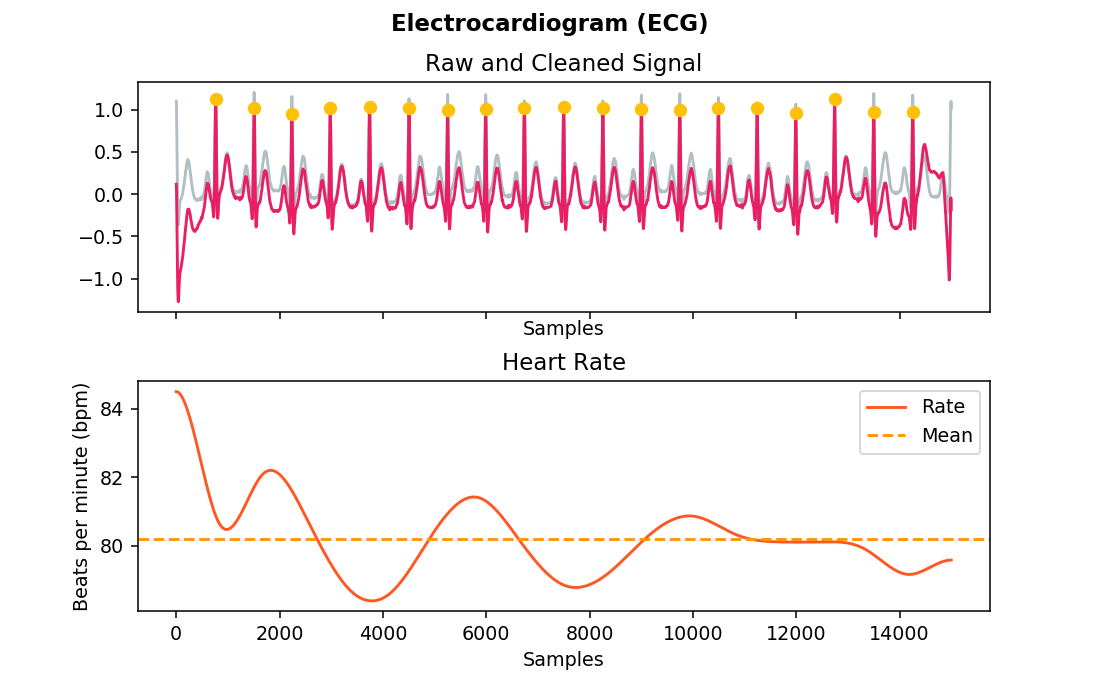

In [24]:
# Simulate ecg signal
ecg = nk.ecg_simulate(duration=15, sampling_rate=1000, heart_rate=80)

# Default processing pipeline
signals, info = nk.ecg_process(ecg, sampling_rate=1000)

# Visualize
plot = nk.ecg_plot(signals)

## Building your own `ecg_process()`


First, let's look at `ecg_clean()`. There are several different methods for cleaning which can be specified, such as: *'neurokit'*, *'biosppy'*, *'pamtompkins1985'*, *'hamilton2002'*, *'elgendi2010'*, *'engzeemod2012'*. The default is the **Neurokit** method, however depending on the quality of your signal (and several other factors), other methods may be more appropriate. It is up to you to make this decision.

Here, we will show you how you are able to change the parameters within a given function to suit your purpose. The following code is the implementation of the *engzeemod2012* method for ECG cleaning.

In [32]:
def _ecg_clean_engzee(ecg_signal, sampling_rate=1000):
    """
    Adapted from https://github.com/berndporr/py-ecg-detectors/

    - C. Zeelenberg, A single scan algorithm for QRS detection and feature extraction, IEEE Comp. in Cardiology, vol. 6, pp. 37-42, 1979
    - A. Lourenco, H. Silva, P. Leite, R. Lourenco and A. Fred, "Real Time Electrocardiogram Segmentation for Finger Based ECG Biometrics", BIOSIGNALS 2012, pp. 49-54, 2012.
    """

    f1 = 48/sampling_rate
    f2 = 52/sampling_rate
    b, a = scipy.signal.butter(4, [f1*2, f2*2], btype='bandstop')
    filtered = scipy.signal.lfilter(b, a, ecg_signal)

    return filtered


In order to use this method for cleaning your ECG signal, you can simply call it using the argument `method='engzeemod2012'`.

In [33]:
# Simulate ecg signal (as shown previously)
ecg = nk.ecg_simulate(duration=15, sampling_rate=1000, heart_rate=80)

# Customize the method for ecg_clean
def ecg_process(ecg_signal, sampling_rate=1000, method="neurokit"):
    '''
    Convenience function that automatically processes an ECG signal.
    Returns a dataframe consisting of the processed signals,
    as well as a dictionary containing information about the ECG peaks.
    '''
    # Clean the signal
    ecg_cleaned = nk.ecg_clean(ecg,
                               sampling_rate=1000,
                               method='engzeemod2012')

    
    # Find R-peaks
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned=ecg_cleaned,
                                          sampling_rate=sampling_rate,
                                          method=method,
                                          correct_artifacts=True)
    
    # Calculate heart rate from R-peaks 
    rate = nk.ecg_rate(rpeaks,
                       sampling_rate=sampling_rate,
                       desired_length=len(ecg_cleaned))
    
    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate})
    signals = pd.concat([signals, instant_peaks], axis=1)
    info = rpeaks
    
    return signals, info

# Process the signal
customized_signals, customized_info = ecg_process(ecg, sampling_rate=1000)

This is simple and quick to do. You have created your own processing pipeline!

Let's go a step further.  For users who want further control over how a signal is processed, you can take a step further and look at the **base-level functions**. For example, the following code shows how the *Neurokit* method is implemented in `ecg_clean()`. 

Note: This function makes use of a Neurokit function, [signal_filter()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.signal_filter).

In [34]:
def _ecg_clean_nk(ecg_signal, sampling_rate=1000):

    # Remove slow drift and dc offset with highpass Butterworth.
    clean = signal_filter(signal=ecg_signal,
                          sampling_rate=sampling_rate,
                          lowcut=0.5,
                          method="butterworth",
                          order=5)
    return clean

Here, the default is implementing a low-pass of 0.5 Hz filtered using the IIR Butterworth B/A method. For customization, you can finetune the parameters according to your needs.

# Visualize different methods of cleaning

In this section, we show you how the same signal, cleaned using different methods look like.

<IPython.core.display.Javascript object>


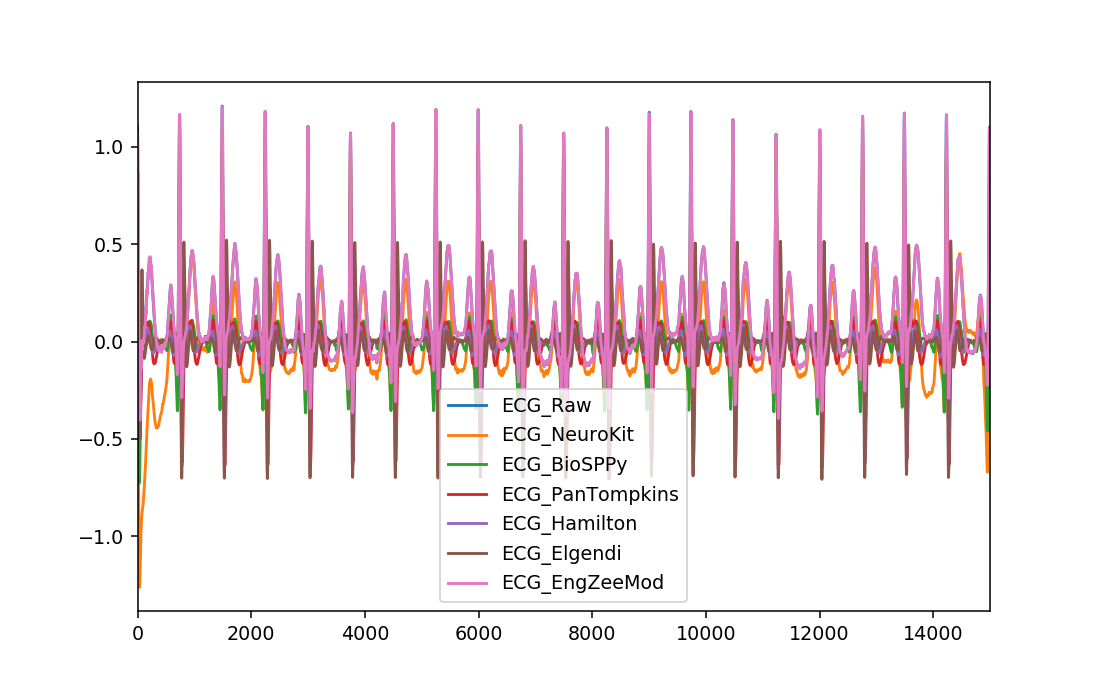

In [35]:
signals = pd.DataFrame({
            "ECG_Raw": ecg,
            "ECG_NeuroKit": nk.ecg_clean(ecg, sampling_rate=1000, method="neurokit"),
            "ECG_BioSPPy":nk.ecg_clean(ecg, sampling_rate=1000, method="biosppy"),
            "ECG_PanTompkins":nk.ecg_clean(ecg, sampling_rate=1000, method="pantompkins1985"),
            "ECG_Hamilton":nk.ecg_clean(ecg, sampling_rate=1000, method="hamilton2002"),
            "ECG_Elgendi":nk.ecg_clean(ecg, sampling_rate=1000, method="elgendi2010"),
            "ECG_EngZeeMod":nk.ecg_clean(ecg, sampling_rate=1000, method="engzeemod2012")})
signals.plot()
